In [1]:
from pyalgotrade import barfeed
from pyalgotrade import bar

# Example BarFeed for dataframes with data for a single instrument.
class DataFrameBarFeed(barfeed.BaseBarFeed):
    def __init__(self, dataframe, instrument, frequency):
        super(DataFrameBarFeed, self).__init__(frequency)
        self.registerInstrument(instrument)
        self.__df = dataframe
        self.__instrument = instrument
        self.__next = 0

    def reset(self):
        super(DataFrameBarFeed, self).reset()
        self.__next = 0

    def peekDateTime(self):
        return self.getCurrentDateTime()

    def getCurrentDateTime(self):
        ret = None
        if not self.eof():
            rowkey = self.__df.index[self.__next]
            ret = rowkey.to_datetime()
        return ret

    def barsHaveAdjClose(self):
        return True

    def getNextBars(self):
        ret = None
        if not self.eof():
            # Convert the dataframe row into a bar.BasicBar
            rowkey = self.__df.index[self.__next]
            row = self.__df.ix[rowkey]
            bar_dict = {
                self.__instrument: bar.BasicBar(
                    rowkey.to_datetime(),
                    row["Open"],
                    row["High"],
                    row["Low"],
                    row["Close"],
                    row["Volume"],
                    row["Adj Close"],
                    self.getFrequency()
                )
            }
            ret = bar.Bars(bar_dict)
            self.__next += 1
        return ret

    def eof(self):
        return self.__next >= len(self.__df.index)

    def start(self):
        pass

    def stop(self):
        pass

    def join(self):
        pass

In [2]:
import datetime
import pandas as pd
import zipfile
import urllib2
from pyalgotrade import strategy
from pyalgotrade.feed import csvfeed
from pyalgotrade import barfeed
from pyalgotrade.technical import ma
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import returns

class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(MyStrategy, self).__init__(feed, 1000000)
        self.__position = None
        self.__instrument = instrument
        # We'll use adjusted close values instead of regular close values.
        self.__sma = ma.EMA(feed[instrument].getPriceDataSeries(), smaPeriod)

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info("BUY at $%.2f" % (execInfo.getPrice()))

    def onEnterCanceled(self, position):
        self.__position = None
    
    def getSMA(self):
        return self.__sma
    
    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info("SELL at $%.2f" % (execInfo.getPrice()))
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        # Wait for enough bars to be available to calculate a SMA.
        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]
        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if bar.getPrice() > self.__sma[-1]:
                # Enter a buy market order for 10 shares. The order is good till canceled.
                NoShares = 0.8*self.getBroker().getCash()/bar.getPrice() -1
                self.__position = self.enterLong(self.__instrument, NoShares, True)
        # Check if we have to exit the position.
        elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():
            self.__position.exitMarket()


def run_strategy(smaPeriod,feed,Ticker):
    # Load the yahoo feed from the CSV file
    # Evaluate the strategy with the feed.
    myStrategy = MyStrategy(feed, Ticker, smaPeriod)
    returnsAnalyzer = returns.Returns()
    myStrategy.attachAnalyzer(returnsAnalyzer)
    #plt = plotter.StrategyPlotter(myStrategy)
    #plt.getInstrumentSubplot("DBC").addDataSeries("SMA", myStrategy.getSMA())    
    #plt.getOrCreateSubplot("returns").addDataSeries("Simple returns", returnsAnalyzer.getReturns())
    myStrategy.run()
    print( "Final portfolio value: $%.2f", myStrategy.getBroker().getEquity())
    return( myStrategy.getBroker().getEquity())
    #plt.plot()
    
def run_strategy_withGraph(smaPeriod,feed,Ticker):
    # Load the yahoo feed from the CSV file
    # Evaluate the strategy with the feed.
    myStrategy = MyStrategy(feed, Ticker, smaPeriod)
    returnsAnalyzer = returns.Returns()
    myStrategy.attachAnalyzer(returnsAnalyzer)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getInstrumentSubplot(Ticker).addDataSeries("SMA", myStrategy.getSMA())    
    plt.getOrCreateSubplot("returns").addDataSeries("Simple returns", returnsAnalyzer.getReturns())
    myStrategy.run()
    print( "Final portfolio value: $%.2f", myStrategy.getBroker().getEquity())
    plt.plot()    
    return( myStrategy.getBroker().getEquity())
def getData(date):
    link = 'http://images1.cafef.vn/data/'+date.strftime('%Y%m%d') + \
    '/CafeF.SolieuGD.Upto'+date.strftime('%d%m%Y') +'.zip'
    #'http://images1.cafef.vn/data/20170303/CafeF.SolieuGD.03032017.zip'
    #http://images1.cafef.vn/data/20170303/CafeF.SolieuGD.Upto03032017.zip
    fileName = '/tmp/history.zip'
    req = urllib2.urlopen(link)
    file = open(fileName, 'wb')
    file.write(req.read())
    file.close()
    exchanges = ['HSX','HNX']
    list_ =[]
    with zipfile.ZipFile(fileName) as myzip:
        for exchange in exchanges:
            with myzip.open('CafeF.'+exchange+'.Upto'+date.strftime('%d.%m.%Y')+'.csv') as myfile:
                data = pd.read_csv(myfile, header = 0,names = ['Ticker','Date','Open','High','Low','Close','Volume'])
                list_.append(data)
    frame = pd.concat(list_)
    frame['Date'] = pd.to_datetime(frame.Date, format='%Y%m%d')
    return(frame)

def pivotData(data):
    pivotedData = data.drop_duplicates(subset =['Date','Ticker'])
    pivotedData = pivotedData.pivot(index='Date',columns = 'Ticker',values ='Close')
    pivotedData.to_csv('/tmp/pivotedData.csv')

In [4]:
aaa = {'STB', (1885215716,1803653429) }
aaa
shares_map

NameError: name 'shares_map' is not defined

In [25]:
data[data.Date==datetime.datetime(2017,11,10)]

str_vn30 = 'STB,KDC,REE,CII,BVH,MBB,VCB,CTG,MWG,DHG,CTD,GAS,SSI,FPT,SBT,VNM,BID,GMD,SAB,BMP,HPG,KBC,ROS,VIC,HSG,DPM,NT2,NVL,MSN,PVD'
vn30_members = str_vn30.split(',')
data[(data.Date==datetime.datetime(2017,11,10)) & (data.Ticker.isin(vn30_members))]
vn30_data = data[(data.Ticker.isin(vn30_members))]
vn30_data.groupby(['Date'])['Inde'].sum()

Date
2000-07-28        1000
2000-07-31         300
2000-08-02         100
2000-08-04         200
2000-08-07        2800
2000-08-09         500
2000-08-11       11000
2000-08-14        7800
2000-08-16        7100
2000-08-18        3100
2000-08-21       10100
2000-08-23       42200
2000-08-25       18900
2000-08-28       36500
2000-08-30        9700
2000-09-01       25500
2000-09-06        2800
2000-09-08       35900
2000-09-11       26500
2000-09-13        1400
2000-09-15       35200
2000-09-18       12600
2000-09-20        8800
2000-09-22        7100
2000-09-25        7300
2000-09-27       18700
2000-09-29       18500
2000-10-02       19200
2000-10-04       17100
2000-10-06       16200
                ...   
2017-10-02    28268530
2017-10-03    35763950
2017-10-04    30909740
2017-10-05    48801950
2017-10-06    35233530
2017-10-09    36338320
2017-10-10    38304820
2017-10-11    51017440
2017-10-12    43690510
2017-10-13    36085610
2017-10-16    43241140
2017-10-17    47568950
2017-1

In [65]:
#vn30_members = sorted(vn30_members)
shares = [int(i) for i in r"""2655350
1053170
398450
830760
176450
4956130
213970
254250
1369700
522740
542920
2695850
2971500
2031960
353900
6496980
251050
595520
236260
1636470
4524960
756430
1081700
16650
5683730
1729980
1951220
2187370
2037660
9270450""".split("\n")]
shares
shares_map = {x:y for x,y in zip(vn30_members, shares)}
#shares_series = vn30_data['Ticker'].map(shares_map)
#vn30_data.loc[:,]
close_px = vn30_data['Close']
vn30_data.loc[:,'Mkt_Cap'] = close_px*shares_series

/Users/ha/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ha/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


$\frac{\text{kA}^2 \text{kP} \text{Ut} \left(e^{t (-(\text{kF}+\text{kM}+\text{kP}))} -1\right)+\text{kA} e^{t (-(\text{kA}+\text{kF}+\text{kM}+\text{kP}+\text{kP2}))} \left(e^{t (\text{kA}+\text{kF}+\text{kM}+\text{kP}+\text{kP2})} (\text{Ut} (\text{kP} (\text{kF}+\text{kM}+\text{kP})-\text{kP2} (\text{kM}+2 \text{kP}))-\text{kP2} \text{Mt} (\text{kF}+\text{kM}+\text{kP}))+\text{Ut} e^{t (\text{kA}+\text{kP2})} (\text{kP2} (\text{kM}+2 \text{kP})-\text{kP} (\text{kF}+\text{kM}+\text{kP}))+\text{kP2} \text{Mt} (\text{kF}+\text{kM}+\text{kP}) e^{t (\text{kF}+\text{kM}+\text{kP})}\right)+e^{t (-(\text{kA}+\text{kF}+\text{kM}+\text{kP}+\text{kP2}))} \left(\text{kP2} \text{Ut} e^{t (\text{kA}+\text{kP2})} (\text{kP2} (\text{kM}+\text{kP})-\text{kP} (\text{kF}+\text{kM}+\text{kP}))-\text{kP2} (\text{kF}+\text{kM}+\text{kP}) e^{t (\text{kF}+\text{kM}+\text{kP})} (\text{Mt} (\text{kF}+\text{kM}+\text{kP}-\text{kP2})+\text{kM} \text{Ut})\right)+\text{kP2} (\text{kF}+\text{kM}+\text{kP}-\text{kP2}) (\text{kF} \text{Mt}+(\text{kM}+\text{kP}) (\text{Mt}+\text{Ut}))}{(\text{kA}+\text{kP2}) (\text{kF}+\text{kM}+\text{kP}) (-\text{kA}+\text{kF}+\text{kM}+\text{kP}-\text{kP2})}$


In [66]:
vn30_data

,Ticker,Date,Open,High,Low,Close,Volume,mkt_cap,Shares_OS,Mkt_Cap
17,VNM,2017-11-10,162.3000,173.8000,162.0000,173.8000,9270450,1.611204e+09,9270450,1.611204e+09
25,VCB,2017-11-10,43.0000,43.6500,42.8000,43.1000,2187370,9.427565e+07,2187370,9.427565e+07
32,VIC,2017-11-10,67.8000,70.0000,65.3000,66.0000,2037660,1.344856e+08,2037660,1.344856e+08
78,SSI,2017-11-10,23.2500,23.4500,23.1500,23.3000,1729980,4.030853e+07,1729980,4.030853e+07
80,STB,2017-11-10,11.1000,11.4500,11.1000,11.4000,1951220,2.224391e+07,1951220,2.224391e+07
85,SBT,2017-11-10,20.4000,21.4500,20.2000,21.4500,5683730,1.219160e+08,5683730,1.219160e+08
101,PVD,2017-11-10,16.9000,17.5000,16.8000,17.1000,4524960,7.737682e+07,4524960,7.737682e+07
110,REE,2017-11-10,33.9500,34.0000,33.6500,33.9000,756430,2.564298e+07,756430,2.564298e+07
112,ROS,2017-11-10,164.0000,179.0000,162.5000,174.6000,1081700,1.888648e+08,1081700,1.888648e+08
114,SAB,2017-11-10,278.1000,278.1000,273.9000,276.5000,16650,4.603725e+06,16650,4.603725e+06


In [56]:
gammas.head()

,timepoint,ROI,subject,BOLD signal
0,0.0,IPS,0,0.513433
1,0.0,IPS,1,-0.414368
2,0.0,IPS,2,0.214695
3,0.0,IPS,3,0.814809
4,0.0,IPS,4,-0.894992


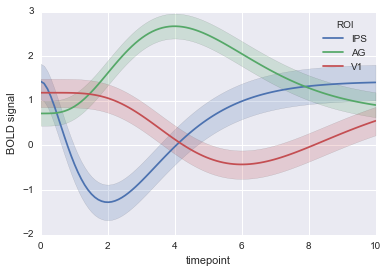

In [55]:
#gammas = sns.load_dataset('gammas')
gammas.describe()
gammas.dtypes
sns.tsplot(gammas, time='timepoint', unit='subject', value='BOLD signal', condition='ROI')

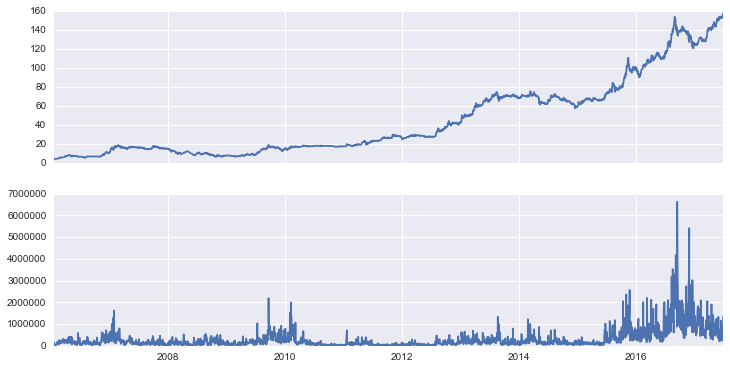

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#pivotData = pivotData(data)
#pivotData = pd.read_csv('/tmp/pivotedData.csv')
vnm = data[data.Ticker=='VNM']
type(vnm)
vnm = vnm.drop_duplicates()
#sns.tsplot(vnm.drop_na(), time='Date',value='Close')
#sns.tsplot(vnm, time = 'Date', )
gs = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[1, 1, 2])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax1.plot(vnm.Date, vnm.Close)
ax2.plot(vnm.Date, vnm.Volume)
f.show()
#vnm.plot('Date', ['Close', 'Volume'], figsize=(12, 6))


In [222]:
df.set_index(df.Date).index.to_pydatetime()

array([datetime.datetime(2016, 1, 4, 0, 0),
       datetime.datetime(2016, 1, 5, 0, 0),
       datetime.datetime(2016, 1, 6, 0, 0),
       datetime.datetime(2016, 1, 7, 0, 0),
       datetime.datetime(2016, 1, 8, 0, 0),
       datetime.datetime(2016, 1, 11, 0, 0),
       datetime.datetime(2016, 1, 12, 0, 0),
       datetime.datetime(2016, 1, 13, 0, 0),
       datetime.datetime(2016, 1, 14, 0, 0),
       datetime.datetime(2016, 1, 15, 0, 0),
       datetime.datetime(2016, 1, 18, 0, 0),
       datetime.datetime(2016, 1, 19, 0, 0),
       datetime.datetime(2016, 1, 20, 0, 0),
       datetime.datetime(2016, 1, 21, 0, 0),
       datetime.datetime(2016, 1, 22, 0, 0),
       datetime.datetime(2016, 1, 25, 0, 0),
       datetime.datetime(2016, 1, 26, 0, 0),
       datetime.datetime(2016, 1, 27, 0, 0),
       datetime.datetime(2016, 1, 28, 0, 0),
       datetime.datetime(2016, 1, 29, 0, 0),
       datetime.datetime(2016, 2, 1, 0, 0),
       datetime.datetime(2016, 2, 2, 0, 0),
       datetime.d

In [260]:
import numpy as np
np.clip( 30, 0, 300)
?np.clip

In [256]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter

#del plot_price_volume

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x*1e-6)


def plot_price_volume( df, bizdays = True ):
    df = df.sort_values('Date')
    df=df.set_index('Date')
    idx = df.index
    fig = plt.figure( figsize=(16,8))
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[3, 1])

    formatter = FuncFormatter(millions)
    N = df.shape[0]
    
    def format_date(x, pos=None):
        thisind = np.clip(int(x+0.5), 0, N - 1)
        return pd.to_datetime(str(df.index.values[thisind])).strftime('%Y-%m-%d')   
    
    #  Varying density along a streamline
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0],sharex=ax0)
    ax1.yaxis.set_major_formatter( FuncFormatter(millions))
    if not bizdays:
        ax0.plot(idx.values, df.Close, 'o-')
        ax1.bar(idx.values, df.Volume)
        
    else:
        ind = np.arange(N)
                
        #ax0.plot_date(idx.to_pydatetime(), df.Close)
        ax0.plot(ind, df.Close, 'o-')
        ax0.xaxis.set_major_formatter(FuncFormatter(format_date))
        ax1.bar( ind, df.Volume )
        ax1.xaxis.set_major_formatter(FuncFormatter(format_date))
        #ax1.bar(idx.values, df.Volume)
        #ax0.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),
        #                                        interval=1))
        #ax0.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
        #fig.autofmt_xdate()

    
    


#pd.to_datetime(str(vnm.Date.values[3])).strftime('%Y-%m-%d')
#plot_price_volume(vnm[vnm.Date > datetime.datetime(2016,01,1,0,0)], bizdays=False)
#plot_price_volume(vnm[vnm.Date > datetime.datetime(2017,04,1,0,0)], bizdays=True)
#ax1.bar([str(x) for x in vnm.Date], vnm.Volume)

In [259]:
df = vnm[vnm.Date > datetime.datetime(2016,01,1,0,0) ]
df = df.sort_values('Date')
df = df.set_index('Date')

df.Close.rolling(window=30).mean()
df.Close.rolling(window=30).std()

Date
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
2016-01-12         NaN
2016-01-13         NaN
2016-01-14         NaN
2016-01-15         NaN
2016-01-18         NaN
2016-01-19         NaN
2016-01-20         NaN
2016-01-21         NaN
2016-01-22         NaN
2016-01-25         NaN
2016-01-26         NaN
2016-01-27         NaN
2016-01-28         NaN
2016-01-29         NaN
2016-02-01         NaN
2016-02-02         NaN
2016-02-03         NaN
2016-02-04         NaN
2016-02-05         NaN
2016-02-15         NaN
2016-02-16         NaN
2016-02-17         NaN
2016-02-18         NaN
2016-02-19    3.598493
                ...   
2017-05-22    2.638285
2017-05-23    2.907630
2017-05-24    3.111060
2017-05-25    3.204388
2017-05-26    3.406992
2017-05-29    3.513833
2017-05-30    3.413840
2017-05-31    3.296135
2017-06-01    3.371898
2017-06-02    3.408832
2017-06-05    3.551259
2017-06-06    3.673436
2017-0

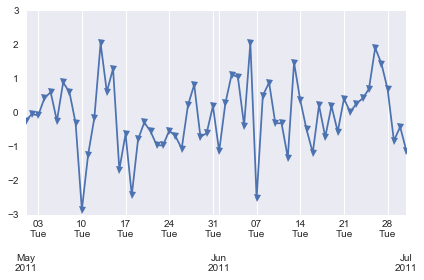

In [199]:
import matplotlib.dates as dates

idx = pd.date_range('2011-05-01', '2011-07-01')
s = pd.Series(np.random.randn(len(idx)), index=idx)

fig, ax = plt.subplots()
ax.plot_date(idx.to_pydatetime(), s, 'v-')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
plt.tight_layout()
plt.show()

In [10]:
data = data.drop_duplicates(subset = ['Date','Ticker'])
dbc = data[data.Ticker == "DBC"]
dbc.reset_index()
print(dbc)

       Ticker       Date     Open     High      Low    Close  Volume
44        DBC 2017-03-31  31.7000  32.4000  31.6000  32.3000  113319
329       DBC 2017-03-30  31.8000  32.2000  31.8000  31.9000  304940
597       DBC 2017-03-29  32.0000  32.5000  31.8000  31.9000    9710
871       DBC 2017-03-28  31.5000  32.3000  31.4000  32.0000  294710
1152      DBC 2017-03-27  31.6000  31.6000  31.4000  31.5000   81370
1431      DBC 2017-03-24  31.9000  31.9000  31.3000  31.6000   85660
1702      DBC 2017-03-23  32.0000  32.0000  31.6000  31.8000   88520
1975      DBC 2017-03-22  32.3000  32.3000  31.4000  31.9000  110720
2249      DBC 2017-03-21  32.4000  32.5000  32.1000  32.3000   35700
2515      DBC 2017-03-20  32.5000  32.8000  31.1000  32.5000   66380
2784      DBC 2017-03-17  31.5000  32.5000  31.0000  32.5000  216754
3052      DBC 2017-03-16  31.1000  32.5000  31.0000  31.5000  111900
3326      DBC 2017-03-15  31.8000  32.0000  31.0000  31.5000   94203
3596      DBC 2017-03-14  33.0000 

In [6]:
dbc.set_index("Date", inplace = True)

In [7]:
print dbc

           Ticker     Open     High      Low    Close  Volume
Date                                                         
2017-03-10    DBC  33.8000  34.2000  33.7000  34.2000  162812
2017-03-09    DBC  34.6000  34.6000  33.6000  33.8000   27621
2017-03-08    DBC  34.0000  34.7000  33.6000  34.1000  215628
2017-03-07    DBC  33.7000  34.0000  33.6000  34.0000   40500
2017-03-06    DBC  34.0000  34.0000  33.7000  33.7000   24540
2017-03-03    DBC  33.2000  34.5000  33.2000  34.0000  458949
2017-03-02    DBC  33.4000  33.5000  33.2000  33.3000   39910
2017-03-01    DBC  33.6000  33.9000  33.3000  33.4000   43300
2017-02-28    DBC  33.3000  34.2000  33.3000  33.6000  258579
2017-02-27    DBC  34.0000  34.0000  33.3000  33.5000   78120
2017-02-24    DBC  33.8000  34.0000  33.2000  34.0000  156999
2017-02-23    DBC  34.1000  34.5000  33.8000  33.8000  186318
2017-02-22    DBC  34.8000  35.0000  34.2000  34.2000  124491
2017-02-21    DBC  34.9000  35.3000  34.6000  34.9000  232884
2017-02-

C:\Users\Duc Thong Nguyen\Anaconda3\envs\pythonBackTest\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Duc Thong Nguyen\Anaconda3\envs\pythonBackTest\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Duc Thong Nguyen\Anaconda3\envs\pythonBackTest\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\

Running for PDR

('Final portfolio value: $%.2f', 1230821.1653999998)


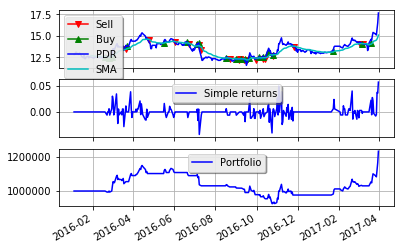

In [17]:
data = data.drop_duplicates(subset = ['Date','Ticker'])
results = pd.DataFrame(columns=('Ticker','PnL','Start','End'))
for Ticker in ['PDR']:
    ss = data[data.Ticker == Ticker]
    ss['Adj Close'] = ss['Close']
    ss.set_index("Date", inplace = True)
    ss.sort_index(inplace = True)      
    ss2015 = ss.loc[ss.index > datetime.datetime(2016,1,1,0,0)]
    condition = ss2015.High < ss2015.Close
    ss2015.High[condition] = ss2015.Close[condition]
    condition = ss2015.High < ss2015.Open
    ss2015.High[condition] = ss2015.Open[condition]  
    condition = ss2015.Low > ss2015.Close
    ss2015.Low[condition] = ss2015.Close[condition]  
    condition = ss2015.Low > ss2015.Open
    ss2015.Low[condition] = ss2015.Open[condition]     
    feed = DataFrameBarFeed(ss2015,Ticker, barfeed.Frequency.DAY)
    print("Running for " + Ticker + "\n")
    PnL = run_strategy_withGraph(20,feed,Ticker)
    Start_Price = ss2015['Close'][0]
    End_Price = ss2015.Close[-1]
    tempDF = pd.DataFrame({'Ticker':[Ticker],'PnL':[(PnL-1000000)/1000000], 'Start':[Start_Price],'End':[End_Price]})
    results = pd.concat([results,tempDF])
plt.show()

In [11]:
from IPython.display import display, HTML
results['YoY Change']= results['End'] - results['Start']
results['Pct YoY Change'] = results['YoY Change']/results['Start']
results = results.sort(["PnL"])
HTML(results.to_html())
results.to_csv('summary.csv')

C:\Users\Duc Thong Nguyen\Anaconda3\envs\pythonBackTest\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


IOError: [Errno 13] Permission denied: 'summary.csv'

In [9]:
Tickers =['VCB',\
'VIC',\
'GAS',\
'CTG',\
'ROS',\
'BID',\
'MSN',\
'BVH',\
'HPG',\
'MWG',\
'MBB',\
'ACB',\
'FPT',\
'STB',\
'CTD',\
'EIB',\
'SSI',\
'VCS',\
'DHG',\
'DPM',\
'HSG',\
'NT2',\
'PVD',\
'BMP',\
'CII',\
'PVS',\
'REE',\
'KDC',\
'HT1',\
'PNJ',\
'VCG',\
'KBC',\
'HNG',\
'SBT',\
'GMD',\
'HAG',\
'TCH',\
'LGC',\
'DCM',\
'SHB',\
'PVI',\
'PHP',\
'GTN',\
'NTP',\
'PPC',\
'KDH',\
'HBC',\
'FLC',\
'BIC',\
'VCF',\
'VHC',\
'PAN',\
'DXG',\
'TRA',\
'HCM',\
'ITA',\
'TLG',\
'DRC',\
'PVT',\
'PGD',\
'ASM',\
'VSH',\
'CAV',\
'NLG',\
'POM',\
'VNR',\
'PDR',\
'DVP',\
'CHP',\
'PTB',\
'VSC',\
'DMC',\
'SKG',\
'DBC',\
'SJS',\
'BMI',\
'NKG',\
'PLC',\
'PHR',\
'IJC',\
'NCT',\
'IMP',\
'PTI',\
]

In [16]:
%matplotlib
import matplotlib.pyplot as plt
stb = data[data.Ticker == 'DBC']
stb['ewa'] = pd.rolling_mean(stb['Close'],20)
stb = stb.set_index(['Date'])
stb = stb.loc[stb.index > datetime.datetime(2016,1,1,0,0)]
stb = stb.sort_index()
plt.figure(50)
stb.plot(y = ['Close','ewa'],grid = True)

Using matplotlib backend: Qt5Agg


C:\Users\Duc Thong Nguyen\Anaconda3\envs\pythonBackTest\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\Users\Duc Thong Nguyen\Anaconda3\envs\pythonBackTest\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
